## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '1d'

# time span of data e.g. 2y for 60m, 10y for 1d
period = '10y'

perc_inc = 0.015 # 1.5 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'IYW' # IYW iShares Technology ETF stock

perc_train = 0.12 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = period
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-06,52.139999,52.500000,51.220001,51.590000,46.875057,160200
2010-07-07,51.770000,53.610001,51.709999,53.580002,48.683186,234800
2010-07-08,54.119999,54.119999,53.240002,53.840000,48.919430,175400
2010-07-09,53.900002,54.169998,53.790001,54.150002,49.201092,145200
2010-07-12,54.049999,54.799999,54.049999,54.560001,49.573616,337700


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Date,,,,,,,
2010-07-06,52.139999,52.500000,51.220001,51.590000,46.875057,160200,0.010549
2010-07-07,51.770000,53.610001,51.709999,53.580002,48.683186,234800,-0.034962
2010-07-08,54.119999,54.119999,53.240002,53.840000,48.919430,175400,0.005174
2010-07-09,53.900002,54.169998,53.790001,54.150002,49.201092,145200,-0.004638
2010-07-12,54.049999,54.799999,54.049999,54.560001,49.573616,337700,-0.009436


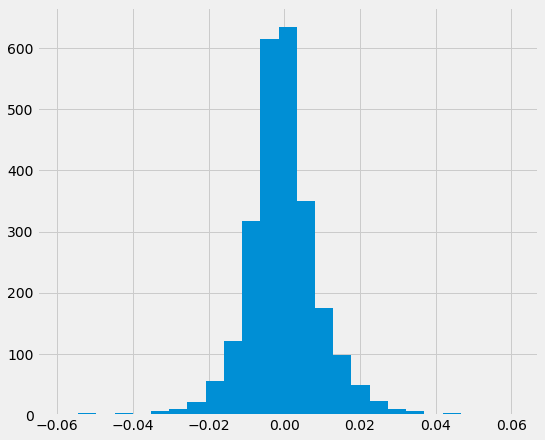

In [6]:
stock_df['percent change'].hist(bins=25);

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.007485
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2020-06-12,259.670013,260.630005,251.440002,255.570007,255.127014,150400,0.015789,0
2020-06-15,250.369995,259.369995,250.350006,258.589996,258.589996,124400,-0.032831,1
2020-06-16,265.320007,265.660004,259.799988,263.739990,263.739990,127400,0.005955,0
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800,0.005387,0
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300,-0.005688,0
2020-06-19,268.450012,268.450012,262.630005,264.230011,264.230011,116900,0.015720,0
2020-06-22,264.470001,268.920013,264.260010,268.739990,268.739990,114800,-0.016145,1
2020-06-23,270.970001,273.350006,269.929993,270.510010,270.510010,272800,0.001698,0
2020-06-24,269.500000,271.070007,263.429993,264.809998,264.809998,228900,0.017403,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

2517

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

2516

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(2516, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open                269.720001
High                272.149994
Low                 268.799988
Close               270.839996
Adj Close           270.839996
Volume            96700.000000
percent change       -0.004152
decision              0.000000
Name: 2020-07-01 00:00:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2010-07-06,52.139999,52.500000,51.220001,51.590000,46.875057,160200,0.010549,1
2010-07-07,51.770000,53.610001,51.709999,53.580002,48.683186,234800,-0.034962,0
2010-07-08,54.119999,54.119999,53.240002,53.840000,48.919430,175400,0.005174,0
2010-07-09,53.900002,54.169998,53.790001,54.150002,49.201092,145200,-0.004638,0
2010-07-12,54.049999,54.799999,54.049999,54.560001,49.573616,337700,-0.009436,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    2391
1     125
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

125

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(250, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    125
0    125
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.6867954911433173

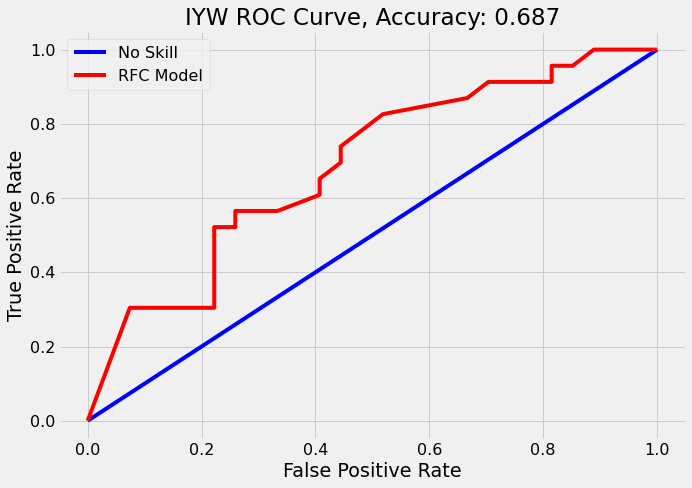

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished


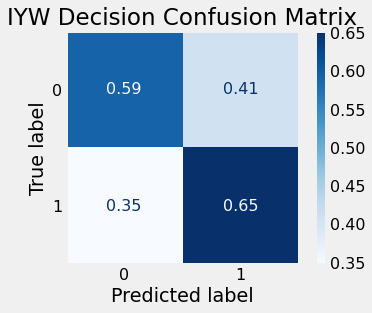

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap=plt.cm.Blues
                             , normalize='true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

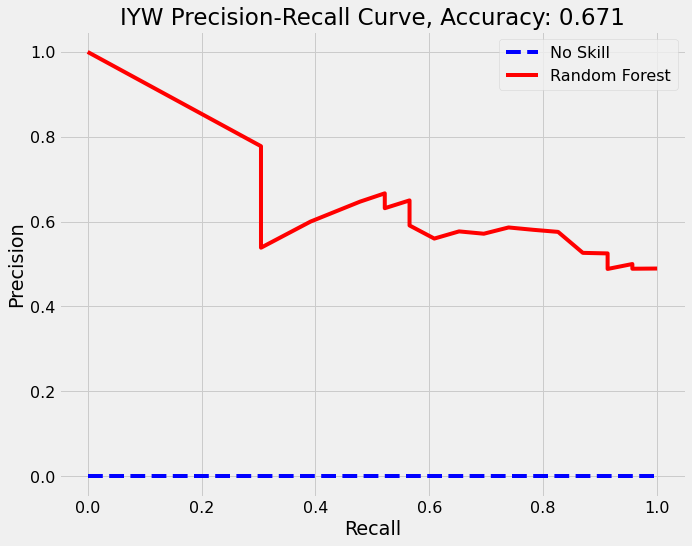

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
5,Volume,0.201560
4,Adj Close,0.174077
3,Close,0.168329
2,Low,0.158162
1,High,0.152404
0,Open,0.145469


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,71.599998,71.820000,71.529999,71.709999,66.308983,144800,-0.001536,0
1,89.760002,90.660004,89.760002,90.430000,84.629135,198300,-0.007464,0
2,65.970001,66.480003,65.660004,66.480003,60.602924,143500,-0.007731,0
3,73.059998,73.150002,72.739998,72.980003,67.665649,181600,0.001095,0
4,75.099998,75.750000,74.889999,75.730003,70.215378,348800,-0.008389,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open           273.510010
High           274.339996
Low            271.809998
Close          272.119995
Adj Close      272.119995
Volume       93100.000000
Name: 2020-07-02 00:00:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Buy IYW on the 1d interval for 1.5% increase.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:    0.0s finished
